### 1) General HDF5 description

- An HDF5 file is a tree of groups (like folders) and datasets (like arrays).

- Groups can contain datasets and other groups. Each dataset has a shape and dtype. Groups/datasets often have attributes (metadata).

- Accessing data with h5py does not load the entire dataset into RAM; a h5py.Dataset supports slicing like dset[i] which reads only that slice.

```text
train.h5
├─ traj_0001/           (group for trajectory/simulation 1)
│  ├─ pos         : (N, 2) or (N,3)           # node coordinates (static)
│  ├─ node_type   : (N, 1)                    # per-node integer flags (static)
│  ├─ velocity    : (T, N, vel_dim)           # time series of velocity
│  ├─ pressure    : (T, N) or (T, N, 1)       # time series of pressure
│  └─ cells       : (num_faces, 3)            # triangle connectivity (static)
├─ traj_0002/
│  ├─ ...
└─ ...
```

Each group stores all arrays for one trajectory (mesh + time series), so groups = trajectories.


### 2) Quick .h5 file inspection

In [1]:
import h5py
import numpy as np

def list_h5_root_keys(h5path):
    with h5py.File(h5path, 'r') as f:
        keys = list(f.keys())
    return keys

def print_group_overview(h5path, group_key, max_print=8):
    """Prints dataset names, shapes and dtypes under the given top-level group."""
    with h5py.File(h5path, 'r') as f:
        g = f[group_key]
        print(f"Group: {group_key}")
        for name, obj in g.items():
            if isinstance(obj, h5py.Dataset):
                print(f"  Dataset: {name}\t shape={obj.shape}\t dtype={obj.dtype}")
                # if small, show a tiny sample
                if obj.size <= max_print:
                    print(f"    sample: {obj[...]}")
                else:
                    # show first row / first slice shape
                    try:
                        small = obj[0]
                        print(f"    first-slice shape {np.asarray(small).shape}")
                    except Exception:
                        pass
            else:
                print(f"  Subgroup: {name}")

def quick_scan_all_groups(h5path, max_groups=10):
    """Prints a compact table for the first `max_groups` groups (safe)."""
    with h5py.File(h5path, 'r') as f:
        keys = list(f.keys())
        print(f"Total top-level groups: {len(keys)}. Showing up to {max_groups}:\n")
        for k in keys[:max_groups]:
            print(f"-- {k} --")
            for name, obj in f[k].items():
                print(f"   {name:12s}  shape={obj.shape} dtype={obj.dtype}")
            print()


In [2]:
import h5py
import itertools

p = "/work/scitas-share/boscario/cylinder_flow_h5/train.h5"

with h5py.File(p, "r") as f:
    keys = list(itertools.islice(f.keys(), 10))  # first 10 keys only
    print("First keys:", keys)


First keys: ['0', '1', '10', '100', '101', '102', '103', '104', '105', '106']


Each top-level key ('0', '1', '10', ...) is a single simulation/trajectory. This means that in this case, the 'traj_0001' name used in the above schematic is really just an integer ('0', '1', ...). Inside groups there are datasets (cells, pos, velocity, pressure, node_type) whose first axis is time (with length 600 in this case). So the **group '0'** is **one simulation** that contains **600 time steps (frames)**.

In [3]:
p = "/work/scitas-share/boscario/cylinder_flow_h5/train.h5"
# print(list_h5_root_keys(p))          # shows all trajectory keys (do not print if thousands)
print_group_overview(p, '0') # inspect a single group
quick_scan_all_groups(p, max_groups=5)


Group: 0
  Dataset: cells	 shape=(600, 3518, 3)	 dtype=int32
    first-slice shape (3518, 3)
  Dataset: node_type	 shape=(600, 1876, 1)	 dtype=int32
    first-slice shape (1876, 1)
  Dataset: pos	 shape=(600, 1876, 2)	 dtype=float32
    first-slice shape (1876, 2)
  Dataset: pressure	 shape=(600, 1876, 1)	 dtype=float32
    first-slice shape (1876, 1)
  Dataset: velocity	 shape=(600, 1876, 2)	 dtype=float32
    first-slice shape (1876, 2)
Total top-level groups: 1000. Showing up to 5:

-- 0 --
   cells         shape=(600, 3518, 3) dtype=int32
   node_type     shape=(600, 1876, 1) dtype=int32
   pos           shape=(600, 1876, 2) dtype=float32
   pressure      shape=(600, 1876, 1) dtype=float32
   velocity      shape=(600, 1876, 2) dtype=float32

-- 1 --
   cells         shape=(600, 3518, 3) dtype=int32
   node_type     shape=(600, 1876, 1) dtype=int32
   pos           shape=(600, 1876, 2) dtype=float32
   pressure      shape=(600, 1876, 1) dtype=float32
   velocity      shape=(600, 187

Group '0' does not contain sub-groups of trajectories, it contains direct datasets. The reason we see shape=(600, 3518, 3) and then first-slice shape (3518, 3) is because the dataset is time-varying: cells.shape == (T, n_faces, 3) and cells[0] (the first-slice) is (n_faces, 3).

How many simulations and time steps total? Total top-level groups: 1000. That means **1000 simulations total** (assuming keys run 0, ..., 999). Each simulation appears to have T = 600 time steps (the first axis of the datasets). So total frames across the file = 1000 × 600 = 600,000 time steps (frames).

Note: different simulations can have different node/face counts (e.g. 1876 nodes in group 0 vs 2000 nodes in group 10), but they all appear to have T = 600.

**Nodes vs. Cells**:

pos.shape = (600, 1876, 2)
- Each trajectory has 600 timesteps.
- At each timestep there are 1876 nodes (mesh vertices).
- Each node has 2 coordinates (x, y) because this is a 2D simulation.

cells.shape = (600, 3518, 3)
- Again 600 timesteps.
- At each timestep there are 3518 cells (triangles).
- Each cell is defined by 3 integers (the **indices** of the nodes that form the triangle).

So:
- cells = connectivity (triangular mesh topology, using 3 node indices per cell).
- pos = geometry (2D coordinates of the nodes).
- node_type, pressure, velocity = nodal attributes evolving over time.

### 3) Determine which datasets are time-varying vs static

In [4]:
def detect_timevarying(h5path, group_key):
    """Return mapping name -> True if time-varying (first dim >1 and matches T)."""
    result = {}
    with h5py.File(h5path, 'r') as f:
        g = f[group_key]
        # if velocity exists, use its first dim as T
        if 'velocity' in g:
            T = g['velocity'].shape[0]
        else:
            T = None
        for name, obj in g.items():
            shape = obj.shape
            if T is not None and len(shape) >= 1 and shape[0] == T:
                result[name] = True
            else:
                result[name] = False
    return result


In [5]:
print(detect_timevarying(p, '0'))
# Example output: {'pos': False, 'node_type': False, 'velocity': True, 'pressure': True, 'cells': False}

{'cells': True, 'node_type': True, 'pos': True, 'pressure': True, 'velocity': True}


In this case every dataset is True but that's because 'pos' for example is just copied along the trajectory (T = 600) dimension. Indeed, the dynamics in the cylinder case is Eulerian.

### 4) Create a small subset

In [1]:
import h5py

def make_subset(h5_in, h5_out, K=500):
    """Copy first K top-level groups from h5_in into h5_out as a new file."""
    with h5py.File(h5_in, 'r') as fin, h5py.File(h5_out, 'w') as fout:
        keys = list(fin.keys())[:K]
        for k in keys:
            fin.copy(k, fout)   # h5py copy works without loading whole arrays into RAM
    print(f"Created subset {h5_out} with groups: {keys}")


In [2]:
make_subset("/work/scitas-share/boscario/cylinder_flow_h5/train.h5", "/work/scitas-share/boscario/cylinder_flow/train_subset.h5")

Created subset /work/scitas-share/boscario/cylinder_flow/train_subset.h5 with groups: ['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '213', '214', '215', '216', '217', 

### 5) Visualize one frame

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import h5py

def plot_frame(h5path, group_key, frame=0, draw='pressure'):
    """Plot nodes + triangular mesh colored by selected draw: 'pressure' or 'speed' """
    with h5py.File(h5path, 'r') as f:
        g = f[group_key]
        pos = np.asarray(g['pos'][frame])           # shape (N,2)
        cells = np.asarray(g['cells'][frame])      # shape (num_faces, 3)
        vel = np.asarray(g['velocity'][frame])  # shape (N, vel_dim)
        # pressure may be (T,N) or (T,N,1)
        p = np.asarray(g['pressure'][frame])
        if p.ndim > 1 and p.shape[1] == 1:
            p = p[:,0]

    # compute field
    if draw == 'pressure':
        field = p
        title = f"Pressure, frame {frame}"
    elif draw == 'speed':
        speed = np.linalg.norm(vel, axis=1)
        field = speed
        title = f"Speed, frame {frame}"
    else:
        raise ValueError("draw must be 'pressure' or 'speed'")

    # Triangulation: cells are indices of vertices for each triangle
    # mtri.Triangulation expects triangles as (triangles, 3) with node indices.
    tri = mtri.Triangulation(pos[:,0], pos[:,1], triangles=cells)

    plt.figure(figsize=(6,5))
    tpc = plt.tripcolor(tri, field, shading='flat')
    plt.gca().set_aspect('equal')
    plt.colorbar(tpc)
    plt.title(title)
    plt.xlabel('x'); plt.ylabel('y')
    plt.show()


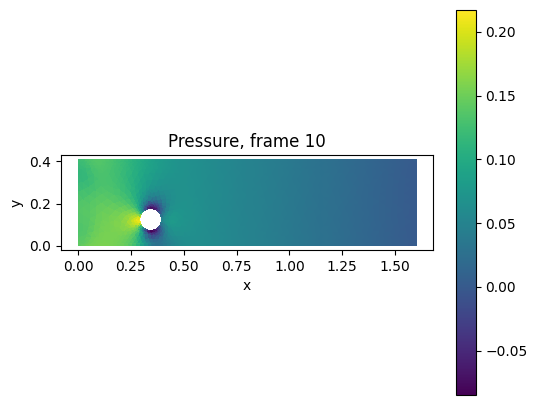

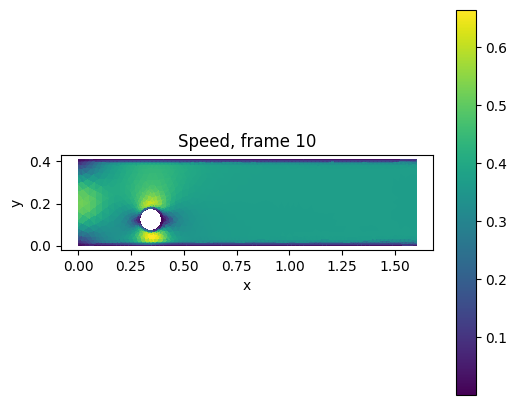

In [9]:
plot_frame("/work/scitas-share/boscario/cylinder_flow_h5_test/train_subset.h5", "0", frame=10, draw='pressure')
plot_frame("/work/scitas-share/boscario/cylinder_flow_h5_test/train_subset.h5", "0", frame=10, draw='speed')
